Imports & Setup

In [31]:
import cv2
import numpy as np
import torch
import clip
from PIL import Image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load video
video_path = "new-prompt.MOV"
target_fps = 2.0

Load Video and Sample Frames

Video FPS: 30.0, Taking every 15th frame
Sampled 16 frames from 231 total frames


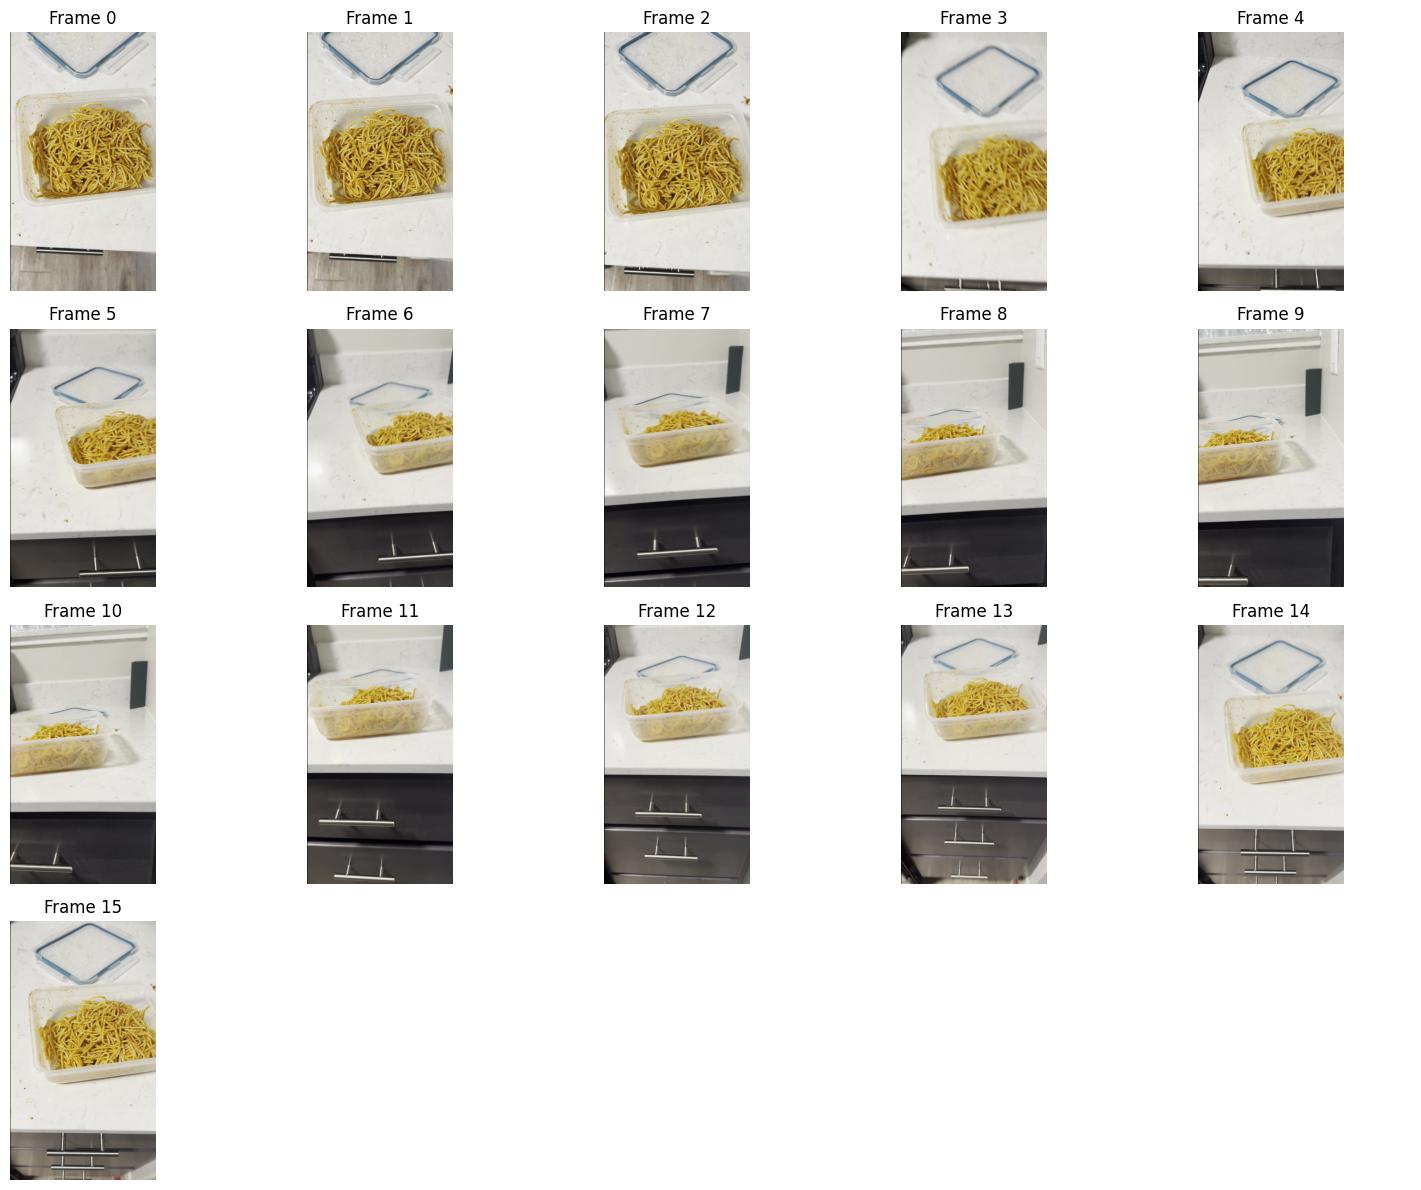

In [32]:
# Open video and get properties
cap = cv2.VideoCapture(video_path)
src_fps = cap.get(cv2.CAP_PROP_FPS)
step = int(src_fps / target_fps)  # Every 15th frame

print(f"Video FPS: {src_fps}, Taking every {step}th frame")

# Sample frames
frames = []
idx = 0
while True:
    ret = cap.grab()
    if not ret: break
    if idx % step == 0:
        ret2, frame = cap.retrieve()
        if ret2: frames.append(frame)
    idx += 1
cap.release()
print(f"Sampled {len(frames)} frames from {idx} total frames")


# Show all sampled frames
n_frames = len(frames)
cols = 5  # frames per row
rows = (n_frames + cols - 1) // cols  # ceiling division
fig, axes = plt.subplots(rows, cols, figsize=(15, 3*rows))
axes = axes.flatten() if rows > 1 else [axes] if rows == 1 else []

for i in range(n_frames):
    axes[i].imshow(cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB))
    axes[i].set_title(f"Frame {i}")
    axes[i].axis('off')

# Hide empty subplots
for i in range(n_frames, len(axes)):
    axes[i].axis('off')
    
plt.tight_layout()
plt.show()

CLIP Angle Analysis

In [33]:
# Load CLIP model
device = "mps" if torch.backends.mps.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Define angle prompts
# Better prompts based on CLIP best practices
angle_prompts = [
    "looking down at food",
    "a side profile photograph of food showing the thickness and height from the side", 
    "a photograph of food taken from table level showing the front view of the plate",
    "an angled photograph of food taken from 45 degrees showing depth and dimension",
    "a close-up macro photograph of food showing texture and individual details"
]

angle_names = ["bird's-eye", "side-profile", "front-view", "angled-shot", "macro-closeup"]

# Get CLIP similarities
imgs = [Image.fromarray(cv2.cvtColor(f, cv2.COLOR_BGR2RGB)) for f in frames]
batch = torch.stack([preprocess(im) for im in imgs]).to(device)
texts = clip.tokenize(angle_prompts).to(device)

with torch.no_grad():
    img_feat = model.encode_image(batch)
    text_feat = model.encode_text(texts)
    similarities = (img_feat @ text_feat.T).cpu().numpy()

print("CLIP angle similarities shape:", similarities.shape)

# Show top 5 similarity scores for each angle prompt
print("\nTop 5 frames for each viewing angle:")
angle_names = ["overhead", "side", "front", "diagonal", "close-up"]

for prompt_idx, angle_name in enumerate(angle_names):
    scores_for_this_angle = similarities[:, prompt_idx]
    top_5_indices = np.argsort(scores_for_this_angle)[-5:][::-1]  # top 5, descending
    
    print(f"\n{angle_name.upper()} view:")
    for rank, frame_idx in enumerate(top_5_indices):
        score = scores_for_this_angle[frame_idx]
        print(f"  {rank+1}. Frame {frame_idx}: {score:.3f}")


CLIP angle similarities shape: (16, 5)

Top 5 frames for each viewing angle:

OVERHEAD view:
  1. Frame 3: 26.125
  2. Frame 6: 25.969
  3. Frame 4: 25.234
  4. Frame 13: 24.812
  5. Frame 14: 24.625

SIDE view:
  1. Frame 15: 22.484
  2. Frame 12: 22.125
  3. Frame 11: 21.859
  4. Frame 14: 21.594
  5. Frame 3: 21.047

FRONT view:
  1. Frame 15: 25.688
  2. Frame 14: 25.328
  3. Frame 3: 25.297
  4. Frame 4: 24.641
  5. Frame 7: 24.578

DIAGONAL view:
  1. Frame 15: 26.484
  2. Frame 14: 25.578
  3. Frame 3: 25.250
  4. Frame 4: 24.359
  5. Frame 11: 24.219

CLOSE-UP view:
  1. Frame 15: 21.500
  2. Frame 1: 21.078
  3. Frame 3: 20.359
  4. Frame 14: 20.109
  5. Frame 0: 19.234


🎯 CLUSTERING FRAMES BY MASK SIMILARITY
    Food AR: 1.36, Circ: 0.30, Spread: 0.16
    Food AR: 1.41, Circ: 0.32, Spread: 0.17
    Food AR: 1.41, Circ: 0.30, Spread: 0.17
    Food AR: 1.28, Circ: 0.41, Spread: 0.15
    Food AR: 1.25, Circ: 0.29, Spread: 0.20
    Food AR: 1.20, Circ: 0.17, Spread: 0.33
    Food AR: 2.38, Circ: 0.37, Spread: 0.34
    Food AR: 1.86, Circ: 0.18, Spread: 0.34
    Food AR: 1.63, Circ: 0.18, Spread: 0.30
    Food AR: 2.06, Circ: 0.52, Spread: 0.31
    Food AR: 2.44, Circ: 0.49, Spread: 0.33
    Food AR: 2.93, Circ: 0.46, Spread: 0.31
    Food AR: 2.01, Circ: 0.21, Spread: 0.50
    Food AR: 1.93, Circ: 0.09, Spread: 0.48
    Food AR: 1.73, Circ: 0.23, Spread: 0.24
    Food AR: 1.60, Circ: 0.24, Spread: 0.23
🔗 SHOWING ALL FRAMES BY CLUSTER:

--- CLUSTER 0: 5 frames ---


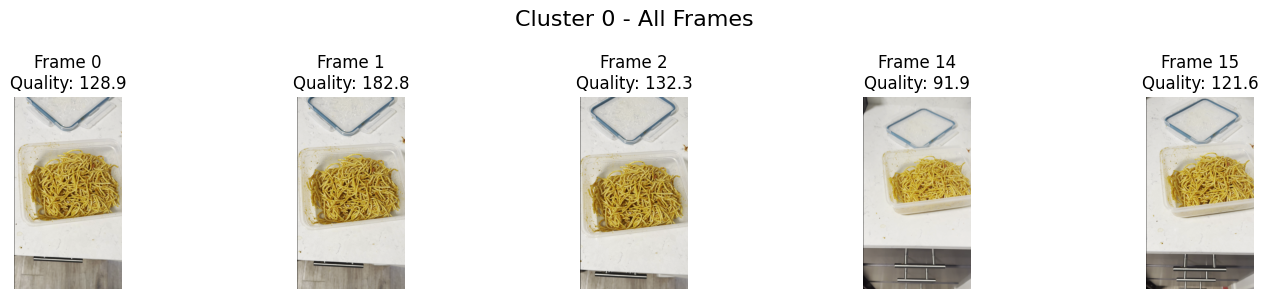


--- CLUSTER 1: 7 frames ---


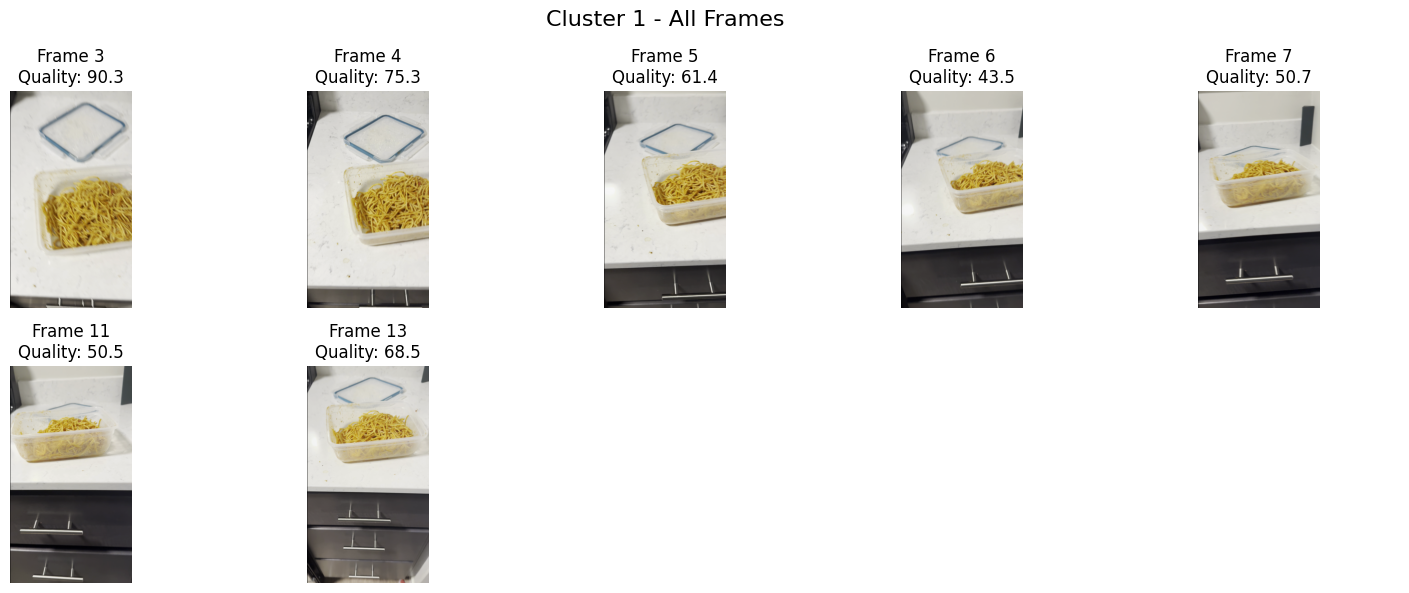


--- CLUSTER 2: 4 frames ---


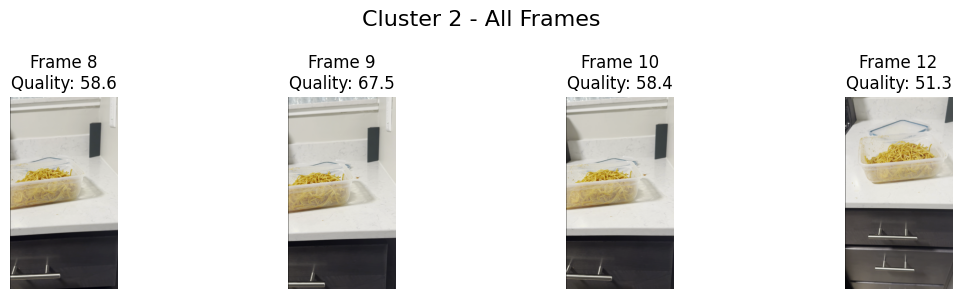


⭐ SELECTED FRAMES (Top 2 per cluster):
Cluster 0: Selected frames [1, 2]
Cluster 1: Selected frames [3, 4]
Cluster 2: Selected frames [9, 8]


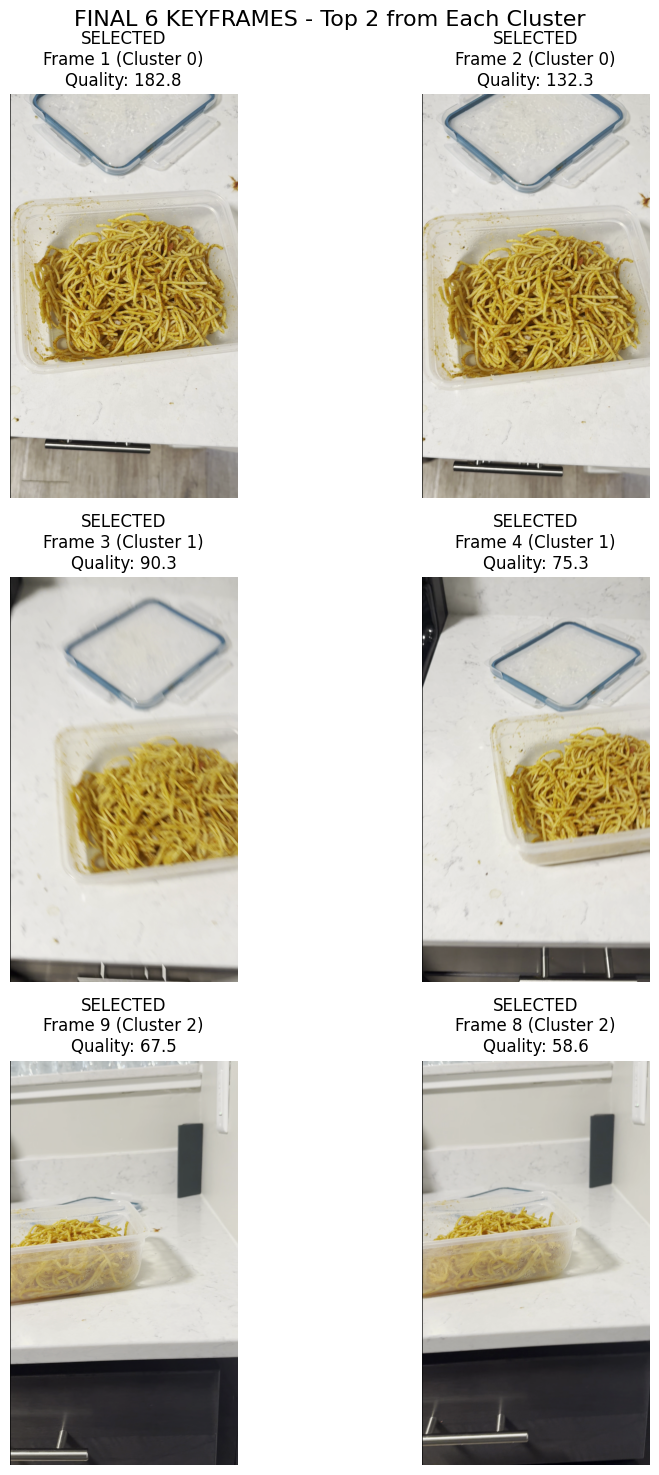


🎉 FINAL SELECTION: Frames [1, 2, 3, 4, 8, 9]


In [34]:
# Cluster frames based on mask similarity, then pick top 2 from each cluster
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

def extract_mask_features(food_mask):
    """Extract features from segmentation mask for clustering"""
    # Resize mask to standard size for comparison
    mask_resized = cv2.resize(food_mask, (64, 64))
    
    # Feature 1: Flattened mask as feature vector
    mask_flat = mask_resized.flatten() / 255.0
    
    # Feature 2: Moments (shape descriptors)
    moments = cv2.moments(mask_resized)
    if moments['m00'] != 0:
        # Hu moments (rotation/scale invariant shape features)
        hu_moments = cv2.HuMoments(moments).flatten()
        # Take log to normalize
        hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)
    else:
        hu_moments = np.zeros(7)
    
    # Feature 3: Basic shape properties
    contours, _ = cv2.findContours(mask_resized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(largest_contour)
        perimeter = cv2.arcLength(largest_contour, True)
        if perimeter > 0:
            circularity = 4 * np.pi * area / (perimeter * perimeter)
            x, y, w, h = cv2.boundingRect(largest_contour)
            aspect_ratio = w / max(h, 1)
            extent = area / (w * h) if (w * h) > 0 else 0
        else:
            circularity = aspect_ratio = extent = 0
    else:
        circularity = aspect_ratio = extent = 0
    
    shape_features = np.array([circularity, aspect_ratio, extent])
    
    # Combine all features
    features = np.concatenate([mask_flat, hu_moments, shape_features])
    return features

print("🎯 CLUSTERING FRAMES BY MASK SIMILARITY")
print("="*50)

# Extract features from all masks
mask_features = []
masks = []
frame_scores = []  # We'll use simple sharpness as quality score

for i in range(len(frames)):
    angle_type, confidence, food_mask = segment_and_analyze_food(frames[i])
    
    # Extract features for clustering
    features = extract_mask_features(food_mask)
    mask_features.append(features)
    masks.append(food_mask)
    
    # Simple quality score (sharpness)
    gray = cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)
    sharpness = cv2.Laplacian(gray, cv2.CV_64F).var()
    frame_scores.append(sharpness)

mask_features = np.array(mask_features)

# Cluster into 3 groups based on mask similarity
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(mask_features)

# Show all frames grouped by cluster
print("🔗 SHOWING ALL FRAMES BY CLUSTER:")

for cluster_id in range(3):
    cluster_frames = [i for i, label in enumerate(cluster_labels) if label == cluster_id]
    print(f"\n--- CLUSTER {cluster_id}: {len(cluster_frames)} frames ---")
    
    # Show frames in this cluster
    n_frames = len(cluster_frames)
    if n_frames > 0:
        cols = min(n_frames, 5)  # Max 5 per row
        rows = (n_frames + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
        if rows == 1 and cols == 1:
            axes = [axes]
        elif rows == 1:
            axes = axes
        else:
            axes = axes.flatten()
        
        for i, frame_idx in enumerate(cluster_frames):
            frame_rgb = cv2.cvtColor(frames[frame_idx], cv2.COLOR_BGR2RGB)
            axes[i].imshow(frame_rgb)
            axes[i].set_title(f"Frame {frame_idx}\nQuality: {frame_scores[frame_idx]:.1f}")
            axes[i].axis('off')
        
        # Hide empty subplots
        for i in range(n_frames, len(axes)):
            axes[i].axis('off')
        
        plt.suptitle(f"Cluster {cluster_id} - All Frames", fontsize=16)
        plt.tight_layout()
        plt.show()

# Select top 2 frames from each cluster based on quality score
selected_frames = []
print("\n⭐ SELECTED FRAMES (Top 2 per cluster):")

for cluster_id in range(3):
    cluster_frames = [i for i, label in enumerate(cluster_labels) if label == cluster_id]
    
    # Sort by quality score (sharpness)
    cluster_frames_sorted = sorted(cluster_frames, key=lambda x: frame_scores[x], reverse=True)
    
    # Take top 2
    top_2 = cluster_frames_sorted[:2]
    selected_frames.extend(top_2)
    
    print(f"Cluster {cluster_id}: Selected frames {top_2}")

# Show the final selected frames in 3 rows x 2 columns
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
axes = axes.flatten()

for i, frame_idx in enumerate(selected_frames):
    frame_rgb = cv2.cvtColor(frames[frame_idx], cv2.COLOR_BGR2RGB)
    axes[i].imshow(frame_rgb)
    
    cluster_id = cluster_labels[frame_idx]
    axes[i].set_title(f"SELECTED\nFrame {frame_idx} (Cluster {cluster_id})\nQuality: {frame_scores[frame_idx]:.1f}")
    axes[i].axis('off')

plt.suptitle("FINAL 6 KEYFRAMES - Top 2 from Each Cluster", fontsize=16)
plt.tight_layout()
plt.show()

print(f"\n🎉 FINAL SELECTION: Frames {sorted(selected_frames)}")

📸 KEYFRAMES READY FOR LLM CALORIE ESTIMATION:
✅ Saved: llm_photos/angle_1_frame_1.jpg
✅ Saved: llm_photos/angle_2_frame_3.jpg
✅ Saved: llm_photos/angle_3_frame_9.jpg


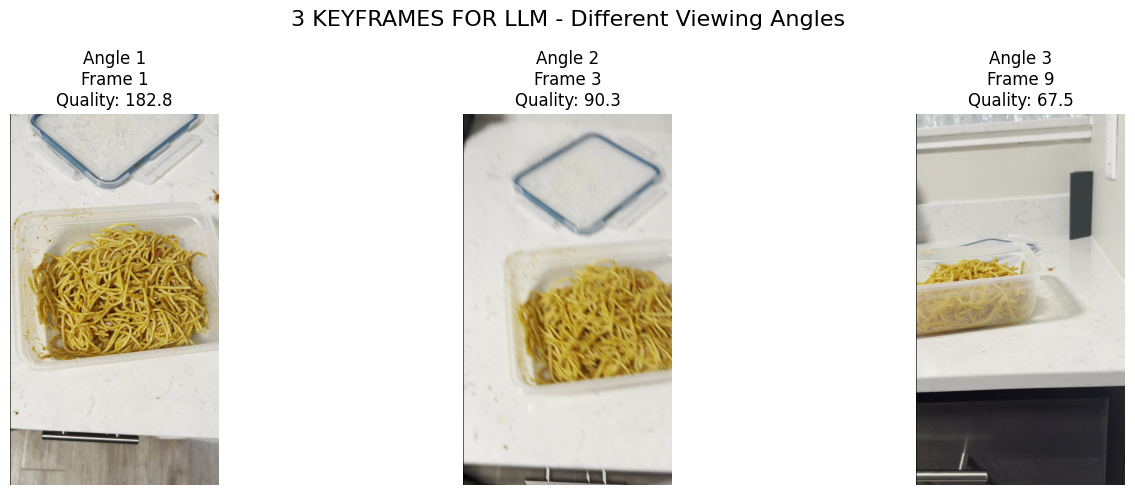


🤖 READY FOR LLM!
Upload these 3 photos showing different angles of your pasta for calorie estimation.


In [35]:
# Prepare the selected keyframes for LLM analysis
print("📸 KEYFRAMES READY FOR LLM CALORIE ESTIMATION:")
print("="*60)

# Save the selected frames for LLM processing
import os
os.makedirs("llm_photos", exist_ok=True)

# Take just one representative from each cluster (3 total)
representative_frames = []
for cluster_id in range(3):
    cluster_frames = [i for i, label in enumerate(cluster_labels) if label == cluster_id]
    # Get the best frame from this cluster
    best_frame = max(cluster_frames, key=lambda x: frame_scores[x])
    representative_frames.append(best_frame)

# Save and display the 3 representative frames
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, frame_idx in enumerate(representative_frames):
    cluster_id = cluster_labels[frame_idx]
    
    # Save frame
    output_path = f"llm_photos/angle_{i+1}_frame_{frame_idx}.jpg"
    cv2.imwrite(output_path, frames[frame_idx])
    
    # Display frame
    frame_rgb = cv2.cvtColor(frames[frame_idx], cv2.COLOR_BGR2RGB)
    axes[i].imshow(frame_rgb)
    axes[i].set_title(f"Angle {i+1}\nFrame {frame_idx}\nQuality: {frame_scores[frame_idx]:.1f}")
    axes[i].axis('off')
    
    print(f"✅ Saved: {output_path}")

plt.suptitle("3 KEYFRAMES FOR LLM - Different Viewing Angles", fontsize=16)
plt.tight_layout()
plt.show()

print(f"\n🤖 READY FOR LLM!")
print("Upload these 3 photos showing different angles of your pasta for calorie estimation.")

In [ ]:

'''
You are an expert food portion analyst who estimates calories from multiple food images taken at different angles.

**Core Skills:**
- Analyze overhead, side, front, and diagonal views to understand 3D food volume
- Use reference objects (plates, utensils, hands) for scale - look up standard dimensions online when needed
- Research visible product brands/packaging for exact specifications
- Convert visual volume to weight using food density knowledge
- Calculate calories from weight estimates

**Process:**
1. Identify reference objects and research their dimensions if needed
2. Estimate 3D volume from multiple viewing angles
3. Convert to weight using food-specific density
4. Calculate calories using nutritional data

**Output:**
- Volume estimate (cups/ml)
- Weight estimate (grams)  
- Calorie estimate
- Confidence level (High/Medium/Low)
- Key reference objects used
- Any online research conducted

Be scientific, acknowledge uncertainty, and research standard object dimensions when scale references are unclear.
First provide an estimate.

 '''

'\nYou are an expert food portion analyst who estimates calories from multiple food images taken at different angles.\n\n**Core Skills:**\n- Analyze overhead, side, front, and diagonal views to understand 3D food volume\n- Use reference objects (plates, utensils, hands) for scale - look up standard dimensions online when needed\n- Research visible product brands/packaging for exact specifications\n- Convert visual volume to weight using food density knowledge\n- Calculate calories from weight estimates\n\n**Process:**\n1. Identify reference objects and research their dimensions if needed\n2. Estimate 3D volume from multiple viewing angles\n3. Convert to weight using food-specific density\n4. Calculate calories using nutritional data\n\n**Output:**\n- Volume estimate (cups/ml)\n- Weight estimate (grams)  \n- Calorie estimate\n- Confidence level (High/Medium/Low)\n- Key reference objects used\n- Any online research conducted\n\nBe scientific, acknowledge uncertainty, and research standar